In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:

import pandas as pd
import numpy as np
import sys, os
from scipy.io import loadmat, savemat 

In [24]:
figsize(8, 8)

In [25]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.manager import SwarmManager
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed


import pandas as pd
import numpy as np
import scipy


from strategies.strategy_swingpoint import StrategySwingPoint
from strategies.strategy_macross_with_trail import StrategyMACrossTrail

In [26]:
# new 2tier ranking settings

# TOP quantile of systems to pick
# 1st tier: picking the best TOP-N quantile members 
ranking_2tier_quantile = 0.9
# 2nd tier: picking the best performing N-periods members
ranking_2tier_nperiods = 14

STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategySwingPoint,
        'exo_name': './mat/strategy_270201.mat',
        'direction': 1,
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1,-1]),
                        OptParam('sphTreshold', 2, 1, 20, 2),
                        OptParam('splTreshold', 2, 1, 20, 2),
                        OptParam('RulesIndex', 0, 0 , 3, 1),
                        OptParam('MedianPeriod', 5, 5, 20, 3)
            ],
    },
    'swarm': {
        'members_count': 5,
        'ranking_function': SwarmRanker.highestreturns_14days,
        'rebalance_time_function': SwarmRebalance.every_monday,    
        
        #'global_filter_function': SwarmFilter.swingpoint_threshold,
        'global_filter_params': {
            'up_factor': 3.0,
            'down_factor': 10.0,
            'period': 5,
        },
        #'global_filter_function': filter_rolling_mean,
        #'global_filter_params': {
        #    'ma_period': 100,
        #}
    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 0.0,
            'costs_futures': 0.0,
        }
    }
}

In [27]:
smgr = SwarmManager(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

In [28]:
def backtest_byleg(matfilepath):
    mat = loadmat(matfilepath)
    
    dollarpnl = pd.Series(mat['dollarPnl'][0])
    pos = mat['optStr']['optPosition'][0][0]
    inposition = np.mean(abs(pos), axis=0)
    legs = mat['optStr']['priceLegSeries'][0][0]
    tickincr = mat['optStr']['tickIncrement'][0][0][0][0]
    tickvalue = mat['optStr']['tickValue'][0][0][0][0]
    exo_price = pd.Series(mat['optStr']['entrySignalingSeries'][0][0][3]/tickincr*tickvalue)
    
    # Size is always = 1.0 according the matlab code
    size = 1.0
    
    equity = np.zeros(len(exo_price))

    RB_IN = 0        # dailyState(kk,RB_IN)
    RB_RT_EXIT = 0   # dailyState(kk,RB_RT_EXIT)
    RB_PNL = 0       # dailyState(kk,RB_PNL)

    for dd in range(1, len(exo_price)):

        if RB_RT_EXIT == 1:        
            if RB_IN == 1:
                #
                # Exiting existing position
                #
                RB_PNL = np.sum(size * pos[:, dd-1]*(legs[:, dd] - legs[:, dd-1])) / tickincr * tickvalue            
                equity[dd] += RB_PNL

            RB_IN = 0
            RB_RT_EXIT = 0

        if RB_IN == 1:
            #
            # Already in position
            #
            RB_PNL = np.sum(size * pos[:, dd-1]*(legs[:, dd] - legs[:, dd-1])) / tickincr * tickvalue            
            equity[dd] += RB_PNL

            # System exit
            if sum(abs(pos[:, dd])) == 0:
                RB_IN = 0
        else:
            if sum(abs(pos[:, dd])) != 0:
                RB_IN = 1
        
    return equity.cumsum(), {'dollarpnl': dollarpnl,
                       'pos': pos,
                       'inposition': inposition,
                       'legs': legs,
                       'tickincr': tickincr,
                       'tickvalue': tickvalue,
                       'exo_price': exo_price}
    

In [29]:
def backtest_byexoprice(matfilepath):
    mat = loadmat(matfilepath)
    
    dollarpnl = pd.Series(mat['dollarPnl'][0])
    pos = mat['optStr']['optPosition'][0][0]
    inposition = np.mean(abs(pos), axis=0)
    legs = mat['optStr']['priceLegSeries'][0][0]
    tickincr = mat['optStr']['tickIncrement'][0][0][0][0]
    tickvalue = mat['optStr']['tickValue'][0][0][0][0]
    exo_price = pd.Series(mat['optStr']['entrySignalingSeries'][0][0][3]/tickincr*tickvalue)
    
    # Size is always = 1.0 according the matlab code
    size = -1.0
    
    equity = np.zeros(len(exo_price))

    RB_IN = 0        # dailyState(kk,RB_IN)
    RB_RT_EXIT = 0   # dailyState(kk,RB_RT_EXIT)
    RB_PNL = 0       # dailyState(kk,RB_PNL)

    for dd in range(1, len(exo_price)):

        if RB_RT_EXIT == 1:        
            if RB_IN == 1:
                #
                # Exiting existing position
                #
                RB_PNL = (size * (exo_price[dd]-exo_price[dd-1]))
                equity[dd] += RB_PNL

            RB_IN = 0
            RB_RT_EXIT = 0

        if RB_IN == 1:
            #
            # Already in position
            #
            RB_PNL = (size * (exo_price[dd]-exo_price[dd-1]))
            equity[dd] += RB_PNL

            # System exit
            if sum(abs(pos[:, dd])) == 0:
                RB_IN = 0
        else:
            if sum(abs(pos[:, dd])) != 0:
                RB_IN = 1
        
    return equity.cumsum(), {'dollarpnl': dollarpnl,
                       'pos': pos,
                       'inposition': inposition,
                       'legs': legs,
                       'tickincr': tickincr,
                       'tickvalue': tickvalue,
                       'exo_price': exo_price}

# Swarm description

In [30]:
data_dict = {}
dollarpnl_dict = {}
for fn in os.listdir('./mat/'):
    equity, mat_info = backtest_byleg('./mat/'+fn)
    
    data_dict[fn] = equity
    dollarpnl_dict[fn] = mat_info['dollarpnl']

swarm = pd.DataFrame(data_dict)   
df_dollarpnl = pd.DataFrame(dollarpnl_dict)

### All swarm members  (TMQR swarm from strategy_xxxxxx.mat)

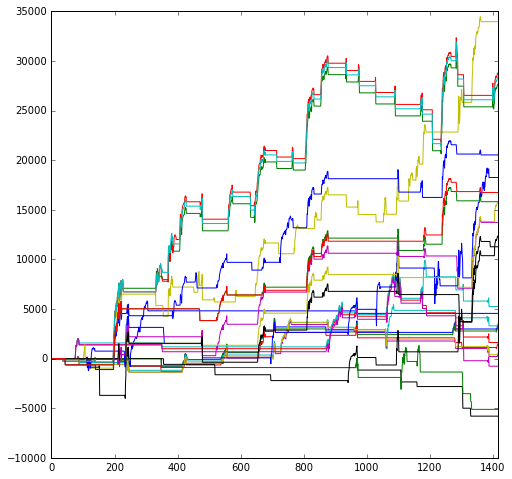

In [31]:
swarm.plot(legend=False)

### All swarm members from Alex's code (SWP Bearish confirmed breakouts)

In [32]:
smgr.swarm

,"(1, 1, 1, 0, 11)","(1, 1, 1, 0, 14)","(1, 1, 1, 0, 17)","(1, 1, 1, 0, 20)","(1, 1, 1, 0, 5)","(1, 1, 1, 0, 8)","(1, 1, 1, 1, 11)","(1, 1, 1, 1, 14)","(1, 1, 1, 1, 17)","(1, 1, 1, 1, 20)",...,"(1, 9, 9, 2, 17)","(1, 9, 9, 2, 20)","(1, 9, 9, 2, 5)","(1, 9, 9, 2, 8)","(1, 9, 9, 3, 11)","(1, 9, 9, 3, 14)","(1, 9, 9, 3, 17)","(1, 9, 9, 3, 20)","(1, 9, 9, 3, 5)","(1, 9, 9, 3, 8)"
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


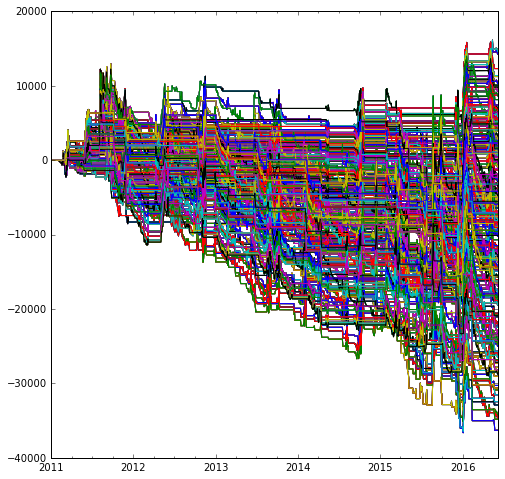

In [33]:
smgr.swarm.plot(legend=False)

# Rebalancing comparison

In [34]:
def is_rebalance_mod7(dateindex):
    return np.mod(range(len(dateindex)), 7) == 0
    
def is_rebalance_monday(dateindex):
    #return dateindex.dayofweek == 0
    
    # We have no datetime index in this script
    # though we just use every 5 day
    return np.mod(range(len(dateindex)), 5) == 0

In [35]:
def ranking_highestreturns_14days(eqty, dollarpnl):       
        return eqty.diff(periods=14)
    
def ranking_mavg_slope(eqty, dollarpnl):
    rebalanceDays = 7
    movAvgDays = 7
    movAvgSpreadSeries = dollarpnl.rolling(movAvgDays).mean()

    #
    # MA slope calculation
    #
    spreadOverAvg = (dollarpnl / movAvgSpreadSeries);

    # MA slope

    slopeDivisor = rebalanceDays;
    slopeLookBack = rebalanceDays;


    movAvgSlope = (movAvgSpreadSeries - movAvgSpreadSeries.shift(slopeLookBack)) / slopeDivisor;

    # Cleaning ratio data
    lowerBoundRatio = 0
    upperBoundRatio = 20
    
    # Ignoring bad values
    spreadOverAvg[spreadOverAvg < lowerBoundRatio] = 0
    spreadOverAvg[spreadOverAvg > upperBoundRatio] = 0
    spreadOverAvg[movAvgSlope < 0] = 0
    
    return spreadOverAvg
    
def ranking_2tier(equity, dollarpnl):
    q = equity.rank(axis=1, pct=True)
    res = pd.DataFrame(0, index=equity.index, columns=equity.columns)

    res[q > ranking_2tier_quantile] = 100

    res += equity/equity.shift(ranking_2tier_nperiods)-1
    
    return res

In [36]:
def pick(swarm, df_dollarpnl, rebalance_func, ranking_func, nSystems, isequity=True):  
    rebalancetime = rebalance_func(swarm.index)
    ranks = ranking_func(swarm, df_dollarpnl) #self.swarm.apply(lambda x: rankerfunc(x, self.rebalancetime))
    is_picked_df = pd.DataFrame(0, index=swarm.index, columns=swarm.columns, dtype=np.int8)
    nbest = None


    def _get_nbest(ranked_results, nsystems):
            # Select N best ranked systems to trade
            nbest = ranked_results.sort_values()


            results = pd.Series(0, index=nbest.index, dtype=np.int8)

            nanless_nbest = nbest[nbest > 0].dropna()

            #
            # Every nbest member value is NaN
            # Not enough data or something wrong with ranked_results
            if len(nanless_nbest) == 0:
                return results

            # Flagging picked trading systems
            results[nanless_nbest[-nsystems:].index] = 1
            return results

    for i in range(len(swarm)):
        if i < 100:
            continue


        # == True - to avoid NaN values to pass condition
        if rebalancetime[i] == True:
            nbest = _get_nbest(ranks.iloc[i], nSystems)
            is_picked_df.iloc[i] = nbest
        else:
            # Flag last picked swarm members until new self.rebalancetime
            if nbest is not None:
                is_picked_df.iloc[i] = nbest

    # Litte bit future referencing but without entry point bug
    eqty_chg = swarm.shift(-1) - swarm
    if isequity:
        return eqty_chg[is_picked_df == 1].sum(axis=1).cumsum().ffill()
    else:
        return eqty_chg[is_picked_df == 1].cumsum().ffill()
    

# Swarm picking test

### Swarm picking from Alex's swarm

In [37]:
eqty_legacy = pick(smgr.swarm, smgr.swarm, is_rebalance_mod7, ranking_mavg_slope, nSystems=3)
eqty_alex_14days = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_14days, nSystems=3)
eqty_alex_2tier = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_2tier, nSystems=3)

# Old ranking algos without BAD equity filtering

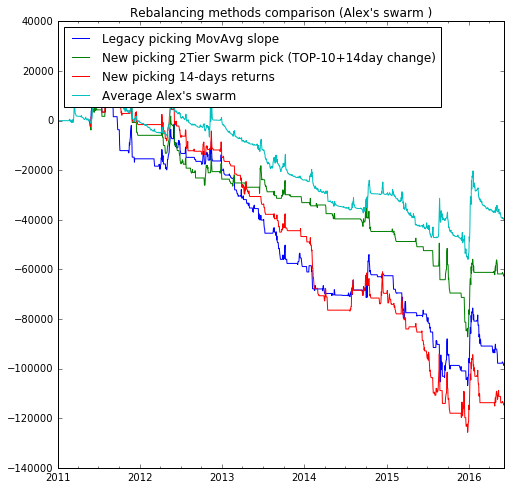

In [38]:
eqty_legacy.plot(label='Legacy picking MovAvg slope');
eqty_alex_2tier.plot(label='New picking 2Tier Swarm pick (TOP-10+14day change)');
eqty_alex_14days.plot(label='New picking 14-days returns');
smgr.swarm_avg.plot(label='Average Alex\'s swarm')

title('Rebalancing methods comparison (Alex\'s swarm )');
legend(loc=2);


# New ranking algos with BAD filter

In [39]:
def ranking_highestreturns_14days_filter_bad(eqty, dollarpnl):       
        diff14 = eqty.diff(periods=14)
        diff30 = eqty.diff(periods=30)
        diff90 = eqty.diff(periods=90)
        
        rank = diff14
        # Filter all members with negative returns in 30 or 90 days
        rank[(diff30 < 0) | (diff90 < 0) | (diff14 < 0)] = 0
        return rank

def ranking_highestreturns_withslope_member_bad(eqty, dollarpnl):       
                
        diff14 = eqty.diff(periods=14)
        
        ma90 = eqty.apply(lambda x: x.rolling(90).mean())
                
        rank = diff14
        # Filter all members with negative returns in 30 or 90 days
        rank[(eqty < ma90) | (ma90-ma90.shift(1) < 0)] = 0
        return rank
    
def ranking_highestreturns_withslope_average_bad(eqty, dollarpnl):       
        avgswarm = eqty.mean(axis=1)
        
        diff14 = eqty.diff(periods=14)
        
        ma90 = avgswarm.rolling(90).mean()
                
        rank = diff14
        # Filter all members with negative returns in 30 or 90 days
        rank[(avgswarm < ma90)] = 0
        return rank

In [40]:
eqty_alex_14days = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_14days, nSystems=3)
eqty_alex_14days_bad = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_14days_filter_bad, nSystems=3)
eqty_alex_14days_slope_avg = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_withslope_average_bad, nSystems=3)
eqty_alex_14days_slope_member = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_withslope_member_bad, nSystems=3)

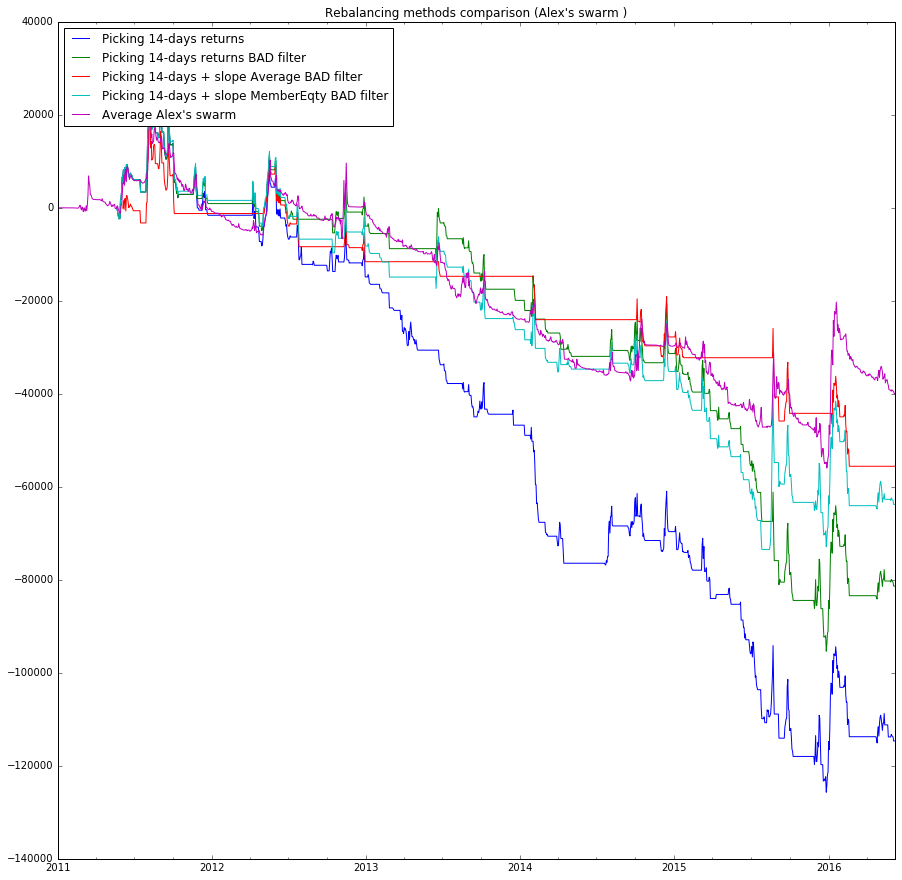

In [41]:
figsize(15, 15)
eqty_alex_14days.plot(label='Picking 14-days returns');
eqty_alex_14days_bad.plot(label='Picking 14-days returns BAD filter');
eqty_alex_14days_slope_avg.plot(label='Picking 14-days + slope Average BAD filter');
eqty_alex_14days_slope_member.plot(label='Picking 14-days + slope MemberEqty BAD filter');
smgr.swarm_avg.plot(label='Average Alex\'s swarm')

title('Rebalancing methods comparison (Alex\'s swarm )');

legend(loc=2);

In [42]:
eqty_slope = pick(smgr.swarm, smgr.swarm, is_rebalance_monday, ranking_highestreturns_withslope_filter_bad, nSystems=3, isequity=False)

NameError: name 'ranking_highestreturns_withslope_filter_bad' is not defined

In [ ]:
eqty_slope.plot(legend=False)